In [221]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import re
import glob
from sklearn.metrics import f1_score,precision_score,recall_score

%matplotlib inline

In [94]:
runname = 'FS269_BEST'
testname = ''
test_value = 0

In [95]:
runname = 'FS280'
testname = 'WEIGHTED_SEG_LOSS_P'
test_value = '0'

In [96]:
runname =  'WS143'
testname = 'DELTA_CLS_LOSS'
test_value = "0.1"

In [97]:
runname =  'FS280_BEST'
testname = ''
test_vals_list = []
paths = glob.glob(f'/{runname}/{testname}/*')
for file in paths:
    inter = os.path.normpath(file)
    test_vals_list.append(inter.split(os.sep)[-1])


In [98]:
runname =  'FS280'
testname = 'NORMAL'
test_vals_list = []
paths = glob.glob(f'E:/AI/FAPS/code/Mixedsupervision/results/PA/WS143/{testname}/*')
for file in paths:
    inter = os.path.normpath(file)
    test_vals_list.append(inter.split(os.sep)[-1])

test_vals_list = ['c']

In [208]:
runname = 'FS280_NO_WEGLOSS'
testname = ''

In [222]:
with open(f'./labels/l_to_i.pyb', "rb") as fp:   #Pickling
    label_image_pair = pickle.load(fp)
with open(f'./labels/i_l.pyb', "rb") as fp:   #Pickling
    image_label_pair = pickle.load(fp)

In [223]:
result_parent_path = '/home/woody/iwfa/iwfa024h/results/PA_M/'

plot_threshold_mean 

 [[0.1        0.62428733 0.62775941]
 [0.2        0.65261817 0.67890613]
 [0.3        0.66447294 0.69540821]
 [0.4        0.67091766 0.70106011]
 [0.5        0.68350945 0.71729547]] 

 plot_threshold_mean_pos 

 [[0.1        0.12326919 0.11846947]
 [0.2        0.15635841 0.17152744]
 [0.3        0.18514858 0.18775523]
 [0.4        0.20080003 0.20282695]
 [0.5        0.23138009 0.24612124]] 

 plot_wrong_count 

 [[ 0.1 84.  87.  39.  40. ]
 [ 0.2 76.  83.  34.  36. ]
 [ 0.3 72.  80.  32.  34. ]
 [ 0.4 70.  80.  31.  34. ]
 [ 0.5 66.  76.  25.  33. ]]


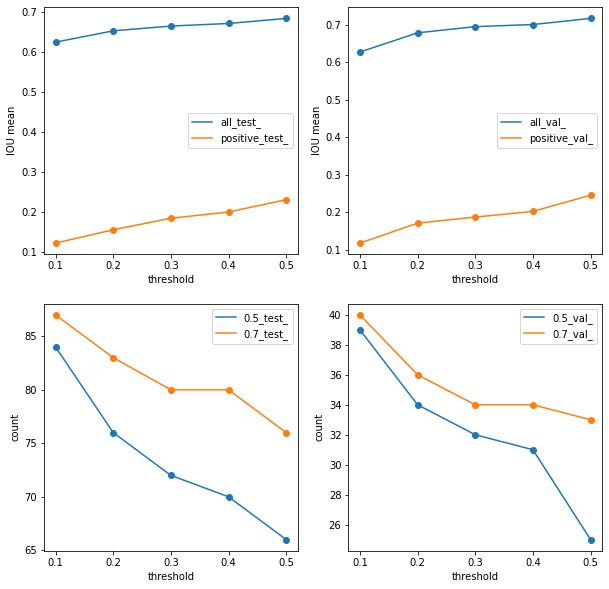

In [212]:
fig,(ax1,ax2) = plt.subplots(2,2,figsize=(10,10))

thresholds = [0.1,0.2,0.3,0.4,0.5]
# thresholds = [0.5]
test_value = ''

plot_threshold_mean = []
plot_threshold_mean_pos = []
plot_wrong_count = [] 
plot_label_count = []

i=0
for thresh in thresholds:

    test_resultcsv_path = os.path.join(result_parent_path,runname,f'TEST_results{thresh*10}.csv').replace("\\",'/')
    val_resultcsv_path = os.path.join(result_parent_path,runname,f'VAL_results{thresh*10}.csv').replace("\\",'/')


    test_df_result = pd.read_csv(test_resultcsv_path)
    val_df_result = pd.read_csv(val_resultcsv_path)

    test_wrong_df = test_df_result[(test_df_result['IOU'] < 0.5)].sort_values('IOU')
    val_wrong_df = val_df_result[(val_df_result['IOU'] < 0.5)].sort_values('IOU')

#     print(wrong_df)
#     print("thresh:",i,f'wrong count:{wrong_df.shape[0]} %{wrong_df.shape[0]/df_result.shape[0]*100//1}')
    plot_wrong_count.append([thresh,test_wrong_df.shape[0],test_df_result.IOU[(test_df_result['IOU'] < 0.7)].shape[0],
                            val_wrong_df.shape[0],val_df_result.IOU[(val_df_result['IOU'] < 0.7)].shape[0]])

    plot_threshold_mean.append([thresh,test_df_result.IOU.mean(),val_df_result.IOU.mean()])
    plot_threshold_mean_pos.append([thresh,test_df_result.IOU[test_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean(),val_df_result.IOU[val_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean()])
#     print('iou',df_result.IOU.mean(),'iou_positive:',df_result.IOU[df_result.ground_truth == True].mean())

    test_imgs = []
    for i in test_wrong_df.index:
        img = test_wrong_df.loc[i].img_name
        test_imgs.append(img)

    val_imgs = []
    for i in val_wrong_df.index:
        img = val_wrong_df.loc[i].img_name
        val_imgs.append(img)

    count_dict = dict.fromkeys(list(label_image_pair.keys()),[0,0])

#     img_dict = {}
    false_ls = []
    for i in test_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][0]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][0] = 1

    false_ls = []
    for i in val_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][1]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][1] = 1
#                 img_dict[l] = [i]

#     print('False classification: ',count_dict)
    plot_label_count.append([thresh,count_dict.copy()])
#     for l in np.sort(np.int32(list(count_dict.keys()))):
#         print(l,count_dict[str(l)]/5)
# df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
plot_threshold_mean = np.array(plot_threshold_mean)
plot_threshold_mean_pos = np.array(plot_threshold_mean_pos)
plot_wrong_count = np.array(plot_wrong_count)

print('plot_threshold_mean','\n\n',plot_threshold_mean, '\n\n','plot_threshold_mean_pos','\n\n',plot_threshold_mean_pos,'\n\n','plot_wrong_count','\n\n',plot_wrong_count)

#     plt.subplot(1,1)
ax1[0].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,1],label='all_test_'+test_value)
ax1[0].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1],label='positive_test_'+test_value)
ax1[0].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,1])
ax1[0].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1])

ax1[1].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,2],label='all_val_'+test_value)
ax1[1].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2],label='positive_val_'+test_value)
ax1[1].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,2])
ax1[1].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2])

for c in [0,1]:   
    ax1[c].legend()
    ax1[c].set_xlabel('threshold')
    ax1[c].set_ylabel('IOU mean')
#     ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

for c in [0,1]:   
    ax2[c].legend()
    ax2[c].set_xlabel('threshold')
    ax2[c].set_ylabel('count')
#     ax2[c].set_ylim(0,204)
plt.savefig('result.jpg')

In [265]:
runname = 'FS280_NO_WEGLOSS'
testname = ''

thresh = 0.5

test_resultcsv_path = os.path.join(result_parent_path,runname,f'TEST_2_results{thresh*10}.csv').replace("\\",'/')
val_resultcsv_path = os.path.join(result_parent_path,runname,f'VAL_2_results{thresh*10}.csv').replace("\\",'/')


test_df_result = pd.read_csv(test_resultcsv_path)
val_df_result = pd.read_csv(val_resultcsv_path)

In [266]:
ious = val_df_result.IOU.apply(lambda x: [float(i) for i in x.split(',')] )
ground_truth = val_df_result.ground_truth.apply(lambda x: [float(i) for i in x.split(',')] )

In [267]:
ious = np.concatenate([np.atleast_2d(a) for a in np.array(ious)],axis=0)
ground_truth = np.concatenate([np.atleast_2d(a) for a in np.array(ground_truth)],axis=0)

In [268]:
counts = dict.fromkeys(np.arange(1,13,dtype = int),[])

In [269]:
pos_ious = []
for i in range(1,13):
    counts[i] = ious[:,i-1][ground_truth[:,i-1] == 1]

In [270]:
counts

{1: array([0.73, 0.82, 0.53, 0.46, 0.74]),
 2: array([0., 0., 0., 0., 1.]),
 3: array([0.77, 0.59, 0.95, 0.82, 0.84]),
 4: array([0.07, 0.  , 0.  , 0.16, 0.42]),
 5: array([0.86, 0.74, 0.94, 0.75, 0.  , 0.95]),
 6: array([0.85, 0.66, 0.  , 0.79, 0.75]),
 7: array([0.71, 0.71, 0.9 , 0.76]),
 8: array([0.35, 0.35, 0.3 , 0.27, 0.81]),
 9: array([0.  , 0.07, 0.  , 0.  , 1.  ]),
 10: array([0.  , 0.32, 0.7 , 0.  , 0.  ]),
 11: array([0.2, 0. , 0. , 0. , 0.2]),
 12: array([0.12, 0.46, 0.51, 0.52, 0.31])}

In [271]:
pos_ious = []
for i in counts.keys():
    pos_ious = np.append(pos_ious,counts[i])

In [272]:
pos_ious.mean()

0.42933333333333334

(0.0, 1.0)

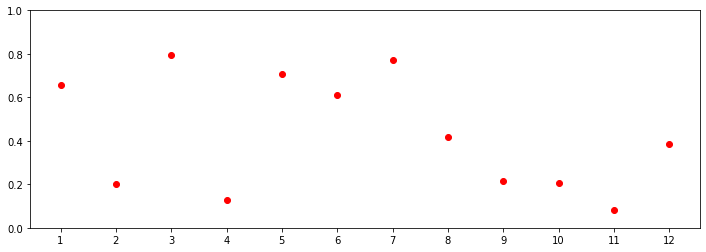

In [273]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
plt.xticks(range(1,13))
plt.ylim(0,1)

(0.0, 1.0)

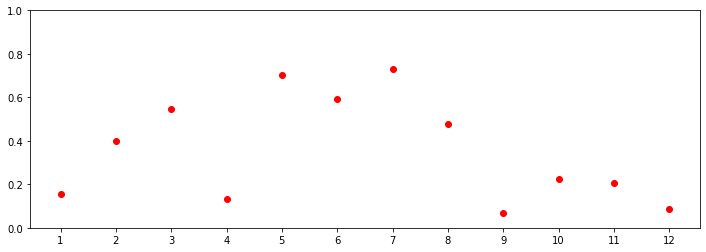

In [264]:
plt.figure(figsize=(12,4))
for i in counts.keys():
    plt.scatter(i,np.mean(counts[i]),c = 'red')
plt.xticks(range(1,13))
plt.ylim(0,1)

In [192]:
test_df_result[test_df_result.img_name == 618]

,prediction,IOU,ground_truth,fscore,img_name
123,"1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0","1,0,0,0,0,0,0,0,0,0,0,0",0.928571,618


In [181]:
np.sort(label_image_pair['1'])

array([601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613,
       614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
       627, 628, 629, 630, 881, 882, 883, 884, 885, 886, 887, 888, 889,
       890, 941, 942, 943, 944, 945, 946, 981, 982, 983, 984])

In [126]:
runname = 'FS280_BEST_3'
testname = ''

plot_threshold_mean 

 [[0.5        0.58823529 0.58823529]] 

 plot_threshold_mean_pos 

 [[5.00000000e-01 1.23539729e-09 1.23539729e-09]] 

 plot_wrong_count 

 [[ 0.5 84.  84.  84.  84. ]]


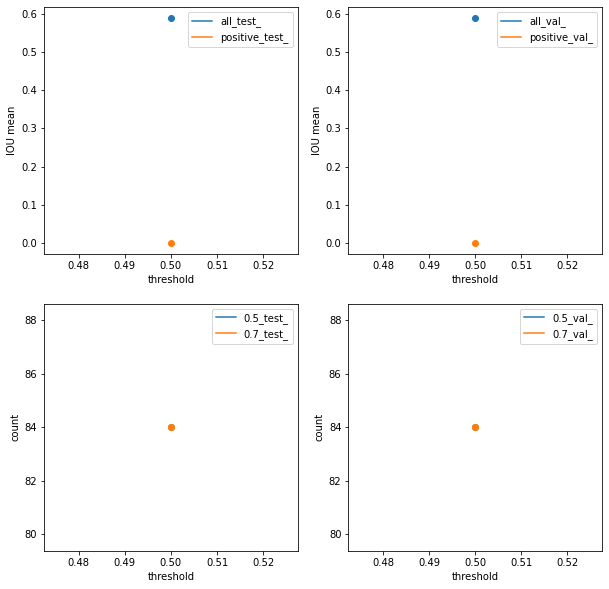

In [127]:
fig,(ax1,ax2) = plt.subplots(2,2,figsize=(10,10))



thresholds = [0.5]
test_value = ''

plot_threshold_mean = []
plot_threshold_mean_pos = []
plot_wrong_count = [] 
plot_label_count = []

i=0
for thresh in thresholds:
    

    test_resultcsv_path = os.path.join(result_parent_path,runname,f'_results{thresh*10}.csv').replace("\\",'/')
    val_resultcsv_path = os.path.join(result_parent_path,runname,f'_results{thresh*10}.csv').replace("\\",'/')


    test_df_result = pd.read_csv(test_resultcsv_path)
    val_df_result = pd.read_csv(val_resultcsv_path)
    
#     test_df_result.columns = ['prediction','IOu', 'ground_truth', 'fscore', 'img_name']
#     val_df_result.columns = ['prediction','fscore', 'ground_truth', 'IOU', 'img_name']

    test_wrong_df = test_df_result[(test_df_result['IOU'] < 0.5)].sort_values('IOU')
    val_wrong_df = val_df_result[(val_df_result['IOU'] < 0.5)].sort_values('IOU')

#     print(wrong_df)
#     print("thresh:",i,f'wrong count:{wrong_df.shape[0]} %{wrong_df.shape[0]/df_result.shape[0]*100//1}')
    plot_wrong_count.append([thresh,test_wrong_df.shape[0],test_df_result.IOU[(test_df_result['IOU'] < 0.7)].shape[0],
                            val_wrong_df.shape[0],val_df_result.IOU[(val_df_result['IOU'] < 0.7)].shape[0]])

    plot_threshold_mean.append([thresh,test_df_result.IOU.mean(),val_df_result.IOU.mean()])
    plot_threshold_mean_pos.append([thresh,test_df_result.IOU[test_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean(),val_df_result.IOU[val_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean()])
#     print('iou',df_result.IOU.mean(),'iou_positive:',df_result.IOU[df_result.ground_truth == True].mean())

    test_imgs = []
    for i in test_wrong_df.index:
        img = test_wrong_df.loc[i].img_name
        test_imgs.append(img)

    val_imgs = []
    for i in val_wrong_df.index:
        img = val_wrong_df.loc[i].img_name
        val_imgs.append(img)

    count_dict = dict.fromkeys(list(label_image_pair.keys()),[0,0])

#     img_dict = {}
    false_ls = []
    for i in test_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][0]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][0] = 1

    false_ls = []
    for i in val_imgs:
        if i not in image_label_pair.keys():
            continue
        for l in image_label_pair[i]:
            false_ls.append(int(l))
            if l in count_dict.keys():
                count_dict[l][1]+=1
#                 img_dict[l].append(i)
            else:
                count_dict[l][1] = 1
#                 img_dict[l] = [i]

#     print('False classification: ',count_dict)
    plot_label_count.append([thresh,count_dict.copy()])
#     for l in np.sort(np.int32(list(count_dict.keys()))):
#         print(l,count_dict[str(l)]/5)
# df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
plot_threshold_mean = np.array(plot_threshold_mean)
plot_threshold_mean_pos = np.array(plot_threshold_mean_pos)
plot_wrong_count = np.array(plot_wrong_count)

print('plot_threshold_mean','\n\n',plot_threshold_mean, '\n\n','plot_threshold_mean_pos','\n\n',plot_threshold_mean_pos,'\n\n','plot_wrong_count','\n\n',plot_wrong_count)

#     plt.subplot(1,1)
ax1[0].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,1],label='all_test_'+test_value)
ax1[0].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1],label='positive_test_'+test_value)
ax1[0].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,1])
ax1[0].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1])

ax1[1].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,2],label='all_val_'+test_value)
ax1[1].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2],label='positive_val_'+test_value)
ax1[1].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,2])
ax1[1].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2])

for c in [0,1]:   
    ax1[c].legend()
    ax1[c].set_xlabel('threshold')
    ax1[c].set_ylabel('IOU mean')
#     ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_test_'+test_value)
ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val_'+test_value)
ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

for c in [0,1]:   
    ax2[c].legend()
    ax2[c].set_xlabel('threshold')
    ax2[c].set_ylabel('count')
#     ax2[c].set_ylim(0,204)
plt.savefig('result.jpg')

In [92]:
test_df_result

,prediction,IOU,ground_truth,fscore,img_name
0,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,4
1,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,7
2,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,10
3,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,15
4,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.000000e+00,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",1.000000,20
...,...,...,...,...,...
199,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.794688e-10,"0,0,0,0,0,0,0,0,0,0,1,1",0.757576,980
200,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.602821e-10,"0,1,0,0,1,1,0,0,0,1,0,0",0.533333,986
201,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",6.852600e-11,"0,0,1,1,0,0,0,0,0,1,0,1",0.533333,989
202,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan",1.006543e-10,"0,0,0,0,0,1,1,0,0,1,0,1",0.533333,996


In [36]:
test_df_result.column

AttributeError: 'DataFrame' object has no attribute 'column'

FileNotFoundError: [Errno 2] File /home/woody/iwfa/iwfa024h/results/PA_M/FS280_BEST/c/TEST/results1.0.csv does not exist: '/home/woody/iwfa/iwfa024h/results/PA_M/FS280_BEST/c/TEST/results1.0.csv'

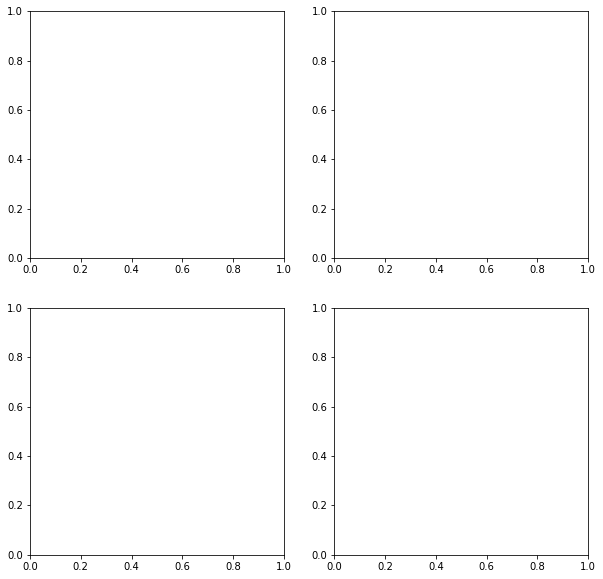

In [37]:

fig,(ax1,ax2) = plt.subplots(2,2,figsize=(10,10))

for test_value in test_vals_list:

# #     print(test_value)
#     result_parent_path =  "E:/AI/FAPS/code/results/PA_M"
#     if test_val !='c':
#         resultcsv_paths = glob.glob(os.path.join(result_parent_path,runname,testname,'resul*.csv'))
# #         print('here')
#     else:
#         resultcsv_paths = glob.glob(os.path.join(result_parent_path,runname,testname,test_value,'resul*.csv'))
#     print(resultcsv_paths)
    thresholds = [0.1,0.2,0.3,0.4,0.5]

    plot_threshold_mean = []
    plot_threshold_mean_pos = []
    plot_wrong_count = [] 
    plot_label_count = []

    

    i=0
    for thresh in thresholds:
        
        if testname == 'NORMAL':
            test_resultcsv_path = os.path.join(result_parent_path,runname,testname,'TEST',f'results{thresh*10}.csv').replace("\\",'/')
            val_resultcsv_path = os.path.join(result_parent_path,runname,testname,'VAL',f'results{thresh*10}.csv').replace("\\",'/')

        else:
            test_resultcsv_path = os.path.join(result_parent_path,runname,testname,test_value,'TEST',f'results{thresh*10}.csv').replace("\\",'/')
            val_resultcsv_path = os.path.join(result_parent_path,runname,testname,test_value,'VAL',f'results{thresh*10}.csv').replace("\\",'/')
        
        test_df_result = pd.read_csv(test_resultcsv_path)
        val_df_result = pd.read_csv(val_resultcsv_path)

        test_wrong_df = test_df_result[(test_df_result['IOU'] < 0.5)].sort_values('IOU')
        val_wrong_df = val_df_result[(val_df_result['IOU'] < 0.5)].sort_values('IOU')

    #     print(wrong_df)
    #     print("thresh:",i,f'wrong count:{wrong_df.shape[0]} %{wrong_df.shape[0]/df_result.shape[0]*100//1}')
        plot_wrong_count.append([thresh,test_wrong_df.shape[0],test_df_result.IOU[(test_df_result['IOU'] < 0.7)].shape[0],
                                val_wrong_df.shape[0],val_df_result.IOU[(val_df_result['IOU'] < 0.7)].shape[0]])

        plot_threshold_mean.append([thresh,test_df_result.IOU.mean(),val_df_result.IOU.mean()])
        plot_threshold_mean_pos.append([thresh,test_df_result.IOU[test_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean(),val_df_result.IOU[val_df_result.ground_truth != "0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"].mean()])
    #     print('iou',df_result.IOU.mean(),'iou_positive:',df_result.IOU[df_result.ground_truth == True].mean())

        test_imgs = []
        for i in test_wrong_df.index:
            img = test_wrong_df.loc[i].img_name
            test_imgs.append(img)

        val_imgs = []
        for i in val_wrong_df.index:
            img = val_wrong_df.loc[i].img_name
            val_imgs.append(img)

        count_dict = dict.fromkeys(list(label_image_pair.keys()),[0,0])

    #     img_dict = {}
        false_ls = []
        for i in test_imgs:
            if i not in image_label_pair.keys():
                continue
            for l in image_label_pair[i]:
                false_ls.append(int(l))
                if l in count_dict.keys():
                    count_dict[l][0]+=1
    #                 img_dict[l].append(i)
                else:
                    count_dict[l][0] = 1

        false_ls = []
        for i in val_imgs:
            if i not in image_label_pair.keys():
                continue
            for l in image_label_pair[i]:
                false_ls.append(int(l))
                if l in count_dict.keys():
                    count_dict[l][1]+=1
    #                 img_dict[l].append(i)
                else:
                    count_dict[l][1] = 1
    #                 img_dict[l] = [i]

    #     print('False classification: ',count_dict)
        plot_label_count.append([thresh,count_dict.copy()])
    #     for l in np.sort(np.int32(list(count_dict.keys()))):
    #         print(l,count_dict[str(l)]/5)
    # df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    plot_threshold_mean = np.array(plot_threshold_mean)
    plot_threshold_mean_pos = np.array(plot_threshold_mean_pos)
    plot_wrong_count = np.array(plot_wrong_count)

    print('plot_threshold_mean','\n\n',plot_threshold_mean, '\n\n','plot_threshold_mean_pos','\n\n',plot_threshold_mean_pos,'\n\n','plot_wrong_count','\n\n',plot_wrong_count)

#     plt.subplot(1,1)
    ax1[0].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,1],label='all_test_'+test_value)
    ax1[0].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1],label='positive_test_'+test_value)
    ax1[0].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,1])
    ax1[0].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,1])
    
    ax1[1].plot(plot_threshold_mean[:,0], plot_threshold_mean[:,2],label='all_val_'+test_value)
    ax1[1].plot(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2],label='positive_val_'+test_value)
    ax1[1].scatter(plot_threshold_mean[:,0], plot_threshold_mean[:,2])
    ax1[1].scatter(plot_threshold_mean_pos[:,0], plot_threshold_mean_pos[:,2])

    for c in [0,1]:   
        ax1[c].legend()
        ax1[c].set_xlabel('threshold')
        ax1[c].set_ylabel('IOU mean')
#         ax1[c].set_ylim(0,1)
#     ax1.legend(loc=4)

#     plt.subplot(2,1)
    ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,1],label='0.5_test_'+test_value)
    ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,1])
    ax2[0].plot(plot_wrong_count[:,0], plot_wrong_count[:,2],label='0.7_test_'+test_value)
    ax2[0].scatter(plot_wrong_count[:,0], plot_wrong_count[:,2])

    ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,3],label='0.5_val_'+test_value)
    ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,3])
    ax2[1].plot(plot_wrong_count[:,0], plot_wrong_count[:,4],label='0.7_val_'+test_value)
    ax2[1].scatter(plot_wrong_count[:,0], plot_wrong_count[:,4])

    for c in [0,1]:   
        ax2[c].legend()
        ax2[c].set_xlabel('threshold')
        ax2[c].set_ylabel('count')
#         ax2[c].set_ylim(0,204)
    plt.savefig('result.jpg')

In [48]:
test_df_result.shape

(204, 5)

TypeError: list indices must be integers or slices, not tuple

[[21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]
 [21 17]]
[[18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]
 [18 21]]
[[23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]
 [23 19]]


(0.0, 30.0)

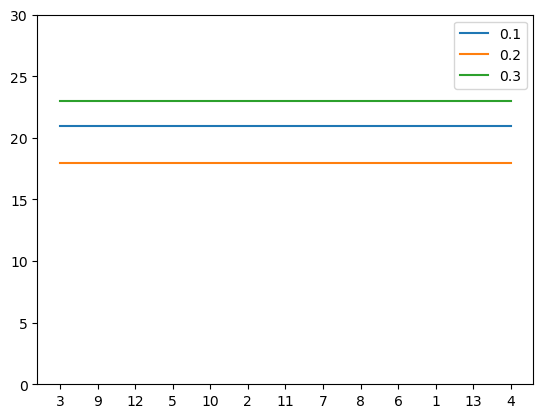

In [50]:
for i,count in plot_label_count[:-2]:
    print(np.array(list(count.values())))
    plt.plot(list(count.keys()), np.array(list(count.values()))[:,0],label=i)
#     plt.scatter(list(count.keys()), list(count.values()),label=i)
plt.legend()
plt.ylim(0,30)

In [343]:

img_dict

False classification:  {'5': 5, '6': 2, '2': 3, '13': 3, '3': 3, '11': 2, '10': 1, '8': 1}


{'5': [948, 985, 994, 993, 700],
 '6': [948, 985],
 '2': [948, 985, 637],
 '13': [985, 994, 993],
 '3': [994, 993, 700],
 '11': [994, 993],
 '10': [994],
 '8': [993]}

2 0.6
3 0.6
5 1.0
6 0.4
8 0.2
10 0.2
11 0.4
13 0.6


(0.0, 5.0)

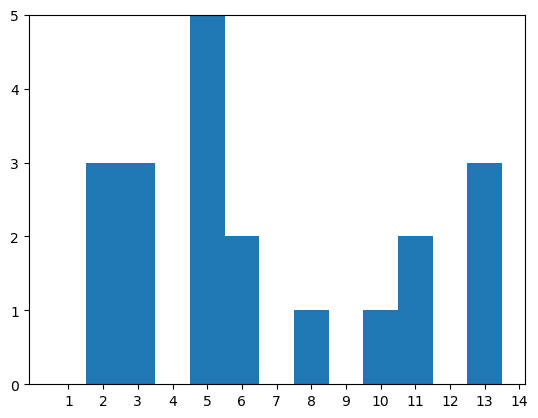

In [334]:
plt.hist(false_ls,bins=np.arange(0.5,14.5,1))
plt.xticks(np.arange(1,15))
plt.ylim(0,5)

In [95]:
with open(f'splits/PA/split_16.pyb', "rb") as f:
    _,_,train_seg_path,test_seg_path,_,_ = pickle.load(f)

In [98]:
count_dict = {}
for img in train_seg_path:
    i = os.path.basename(os.path.normpath(img))
    i = int(i[:-4])
    if i not in image_label_pair.keys():
        continue
    for l in image_label_pair[i]:
        if l in count_dict.keys():
            count_dict[l]+=1
        else:
            count_dict[l] = 1
print('train segmenation count: ',count_dict)   

train segmenation count:  {'4': 4, '13': 6, '9': 3, '12': 6, '3': 11, '10': 1, '8': 2, '5': 1, '7': 1, '11': 2, '6': 1, '2': 1}


In [99]:
count_dict = {}
for img in test_seg_path:
    i = os.path.basename(os.path.normpath(img))
    i = int(i[:-4])
    if i not in image_label_pair.keys():
        continue
    for l in image_label_pair[i]:
        if l in count_dict.keys():
            count_dict[l]+=1
        else:
            count_dict[l] = 1
print('test segmenation count: ',count_dict)  

test segmenation count:  {'11': 9, '13': 12, '3': 64, '12': 13, '8': 10, '7': 16, '10': 15, '4': 14, '9': 15, '6': 13, '1': 11, '5': 6, '2': 8}


In [ ]:
result_parent_path =  "E:/AI/FAPS/code/Mixedsupervision/results/KSDD2"
test_paths = ['N_246','N_126','N_53','N_16','N_0']
for testname in test_paths:
    resultcsv_path = os.path.join(result_parent_path,testname,'results.csv').replace("\\",'/')
    df_result = pd.read_csv(resultcsv_path)
    df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    
    print(testname,f1_score(df_result.ground_truth,df_result.decision),precision_score(df_result.ground_truth,df_result.decision),recall_score(df_result.ground_truth,df_result.decision))
    wrong_df = df_result.loc[df_result['decision'] != df_result['ground_truth'],:]

In [ ]:
result_parent_path =  "E:/AI/FAPS/code/Mixedsupervision/results/PA"
test_paths = ['WS288','WS126','WS53','WS16 - Copy','WS0 - Copy']
for testname in test_paths:
    resultcsv_path = os.path.join(result_parent_path,testname,'results.csv').replace("\\",'/')
    df_result = pd.read_csv(resultcsv_path)
    df_result.loc[:,'ground_truth'] =  df_result.loc[:,'ground_truth'] == 1
    
    print(testname,f1_score(df_result.ground_truth,df_result.decision),precision_score(df_result.ground_truth,df_result.decision),recall_score(df_result.ground_truth,df_result.decision))
    wrong_df = df_result.loc[df_result['decision'] != df_result['ground_truth'],:]